In [67]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import ndcg_score, accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.preprocessing import LabelEncoder

import pickle

Import training data

In [68]:
training_data = pd.read_csv('data/training_set_VU_DM.csv')

Create target (derived from clicked - 1, booked - 5)

In [69]:
training_data['target'] = (5*training_data['booking_bool']) + training_data['click_bool']

Create property count feature

In [70]:
z = training_data['prop_id'].value_counts() 
dict_z = z.to_dict() # converts to dictionary
training_data['prop_counts'] = training_data['prop_id'].map(dict_z)

Create price difference feature

In [71]:
training_data['diff_price'] = ((training_data['price_usd']) - (np.exp(training_data['prop_log_historical_price'])))

Create distance between home location and destination location as feature

In [72]:
training_data['dist_home_away'] = (training_data['visitor_location_country_id']/training_data['prop_country_id'])
training_data.loc[training_data['dist_home_away']!=1, ['dist_home_away']] = 0

Create combined location score feature

In [73]:
training_data['prop_loc_score1_norm'] = training_data['prop_location_score1'] / training_data['prop_location_score1'].abs().max()
training_data['prop_location_score2'].fillna(training_data['prop_loc_score1_norm'], inplace=True)
training_data['location_score'] = (training_data['prop_loc_score1_norm'] + training_data['prop_location_score2'])/2
training_data = training_data.drop('prop_loc_score1_norm', axis=1)

In [74]:
training_data

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,target,prop_counts,diff_price,dist_home_away,location_score
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,0.0,NaN,0,NaN,0,0,612,-36.404964,0.0,0.224622
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,0.0,NaN,0,NaN,0,0,583,17.806987,0.0,0.165043
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,0.0,NaN,0,NaN,0,0,551,42.797387,0.0,0.169843
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,0.0,5.0,0,NaN,0,0,460,522.129581,0.0,0.208972
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,0.0,NaN,0,NaN,0,0,665,5.200488,0.0,0.251162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958342,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,77700,3,4.0,...,NaN,NaN,0,NaN,0,0,47,117.000000,1.0,0.138880
4958343,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,88083,3,4.0,...,NaN,NaN,0,NaN,0,0,38,88.000000,1.0,0.215685
4958344,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,94508,3,3.5,...,NaN,NaN,0,NaN,0,0,43,98.000000,1.0,0.086997
4958345,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,128360,3,5.0,...,NaN,NaN,1,157.84,1,6,37,138.000000,1.0,0.172785


In [75]:
model_traindata = training_data[['srch_id',
                                 'site_id',
                                 'visitor_location_country_id',
                                 'prop_country_id',
                                 'prop_id',
                                 'prop_starrating',
                                 'prop_review_score',
                                 'prop_brand_bool',
                                 'prop_log_historical_price',
                                 'price_usd',
                                 'promotion_flag',
                                 'srch_destination_id',
                                 'srch_length_of_stay',
                                 'srch_booking_window',
                                 'srch_adults_count',
                                 'srch_children_count',
                                 'srch_room_count',
                                 'srch_saturday_night_bool',
                                 'orig_destination_distance',
                                 'random_bool',
                                 'target',
                                 'prop_counts',
                                 'diff_price',
                                 'dist_home_away',
                                 'location_score'
                                ]]

In [76]:
model_traindata.isnull().values.ravel().sum()

1615146

In [77]:
model_traindata = model_traindata.dropna().reset_index(drop=True)
# model_traindata = model_traindata.fillna(0)

In [78]:
model_traindata

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_log_historical_price,price_usd,...,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,target,prop_counts,diff_price,dist_home_away,location_score
0,4,5,219,219,3625,4,4.0,0,5.98,295.0,...,0,1,1,238.35,1,0,431,-100.440368,1.0,0.357859
1,4,5,219,219,11622,4,4.0,0,5.64,299.0,...,0,1,1,238.34,1,0,478,17.537282,1.0,0.388252
2,4,5,219,219,11826,5,4.5,1,6.10,373.0,...,0,1,1,238.33,1,0,505,-72.857770,1.0,0.326859
3,4,5,219,219,22824,3,4.0,0,5.74,329.0,...,0,1,1,238.29,1,0,360,17.935589,1.0,0.419974
4,4,5,219,219,37581,5,4.5,0,6.21,600.0,...,0,1,1,238.35,1,0,306,102.298749,1.0,0.346747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346873,332785,5,219,219,77700,3,4.0,1,0.00,118.0,...,0,1,0,550.92,0,0,47,117.000000,1.0,0.138880
3346874,332785,5,219,219,88083,3,4.0,1,0.00,89.0,...,0,1,0,553.14,0,0,38,88.000000,1.0,0.215685
3346875,332785,5,219,219,94508,3,3.5,1,0.00,99.0,...,0,1,0,544.43,0,0,43,98.000000,1.0,0.086997
3346876,332785,5,219,219,128360,3,5.0,1,0.00,139.0,...,0,1,0,550.38,0,6,37,138.000000,1.0,0.172785


In [32]:
gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(model_traindata, groups=model_traindata['srch_id'])

X_train_inds, X_test_inds = next(gss)

train_data= model_traindata.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['srch_id','target'])]
y_train = train_data.loc[:, train_data.columns.isin(['target'])]

groups = train_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

test_data= model_traindata.iloc[X_test_inds]

# We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['target'])]
# X_test = test_data.loc[:, ~test_data.columns.isin(['srch_id','target'])]
y_test = test_data.loc[:, test_data.columns.isin(['target'])]

In [13]:
X_train.columns

Index(['site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_id',
       'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool',
       'prop_counts', 'diff_price', 'dist_home_away', 'location_score'],
      dtype='object')

In [14]:
X_test.columns

Index(['srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool',
       'prop_counts', 'diff_price', 'dist_home_away', 'location_score'],
      dtype='object')

HYPERPARAMETER OPTIMIZATION

In [15]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate' : hp.uniform('learning_rate', 0.05, 0.2),
        'eta' : hp.uniform('eta', 0.05, 0.2),
        'n_estimators': hp.quniform('n_estimators', 90,180, 5),
        'seed': 0
    }

In [16]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [17]:
def objective(space):
    model=xgb.XGBRanker(tree_method='hist',booster='gbtree',objective='rank:ndcg',
                    n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),learning_rate = space['learning_rate'],eta = space['eta'],verbosity=1)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=True)
    

    pred = model.predict(X_test)
    
    accuracy = ndcg_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [18]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)

In [19]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

def objective(space):
    model=xgb.XGBClassifier(tree_method='hist',booster='gbtree',objective='rank:ndcg',
                    n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = 
                    space['gamma'],reg_alpha =
                    int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),learning_rate = space['learning_rate'],eta =
                    space['eta'],verbosity=1)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=True)
    

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)


The best hyperparameters are :  

{'colsample_bytree': 0.9956497639399737, 'eta': 0.10615342984333002, 'gamma': 4.7115967519155895, 'learning_rate': 0.180656005953109, 'max_depth': 3.0, 'min_child_weight': 1.0, 'n_estimators': 145.0, 'reg_alpha': 128.0, 'reg_lambda': 0.15214262459317351}

In [20]:
model = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    learning_rate=0.05,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=3, 
    n_estimators=150, 
    subsample=0.75,
    verbosity=1
    )

# model = xgb.XGBRanker(
#     verbosity=2,
#     tree_method='hist',
#     booster='gbtree',
#     objective='rank:ndcg',
#     random_state=42, 
#     reg_alpha=128,
#     reg_lambda=0.15214262459317351,
#     learning_rate=0.180656005953109,
#     colsample_bytree=0.9956497639399737, 
#     gamma=4.7115967519155895,
#     eta=0.10615342984333002, 
#     max_depth=3, 
#     min_child_weight=1,
#     n_estimators=145
# #     subsample=0.75 
#     )

model.fit(X_train, y_train, group=groups, verbose=True)

KeyboardInterrupt: 

In [ ]:
# filename = 'XGB_model_rankndcg_dart2.sav'
# pickle.dump(model, open(filename, 'wb'))

In [33]:
filename = 'XGB_model_rankndcg_dart.sav'
model = pickle.load(open(filename, 'rb'))

In [34]:
model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=None, booster='dart', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.9,
          early_stopping_rounds=None, enable_categorical=False, eta=0.05,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=110, n_jobs=None,
          num_parallel_tree=None, objective='rank:ndcg', ...)

In [35]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['srch_id'])])
  
predictions = (X_test.groupby('srch_id').apply(lambda x: predict(model, x)))

In [36]:
y_pred = []

for p in predictions:
    p = list(p)
    y_pred.extend(p)

In [37]:
X_test["predicted_ranking"] = y_pred

In [38]:
X_test

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_log_historical_price,price_usd,...,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,prop_counts,diff_price,dist_home_away,location_score,predicted_ranking
296,47,14,100,137,6618,3,4.0,0,4.78,118.94,...,1,1,0,5592.09,0,51,-0.164350,0.0,0.370445,-0.098549
297,47,14,100,137,11747,4,4.5,0,5.34,113.86,...,1,1,0,5592.33,0,43,-94.652710,0.0,0.360632,1.274081
298,47,14,100,137,18311,4,4.0,0,5.44,129.10,...,1,1,0,5592.60,0,46,-101.342183,0.0,0.349819,1.117984
299,47,14,100,137,19599,3,4.0,0,5.03,94.54,...,1,1,0,5591.92,0,48,-58.393013,0.0,0.380344,0.834350
300,47,14,100,137,24002,4,4.5,0,5.60,185.02,...,1,1,0,5592.13,0,41,-85.406407,0.0,0.388494,0.686677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346867,332784,24,219,100,114177,4,4.5,1,0.00,300.74,...,0,1,0,328.90,0,526,299.740000,0.0,0.385708,-0.697547
3346868,332784,24,219,100,115562,4,4.0,1,0.00,213.15,...,0,1,0,328.83,0,281,212.150000,0.0,0.374092,0.016004
3346869,332784,24,219,100,121275,4,4.0,0,0.00,193.87,...,0,1,0,329.68,0,406,192.870000,0.0,0.375984,0.647570
3346870,332784,24,219,100,128677,3,3.5,1,0.00,107.05,...,0,1,0,328.72,0,379,106.050000,0.0,0.400398,0.616752


In [40]:
print("--> NDCG : ", ndcg_score([y_test['target']],[X_test['predicted_ranking']]))

--> NDCG :  0.7608784443392484


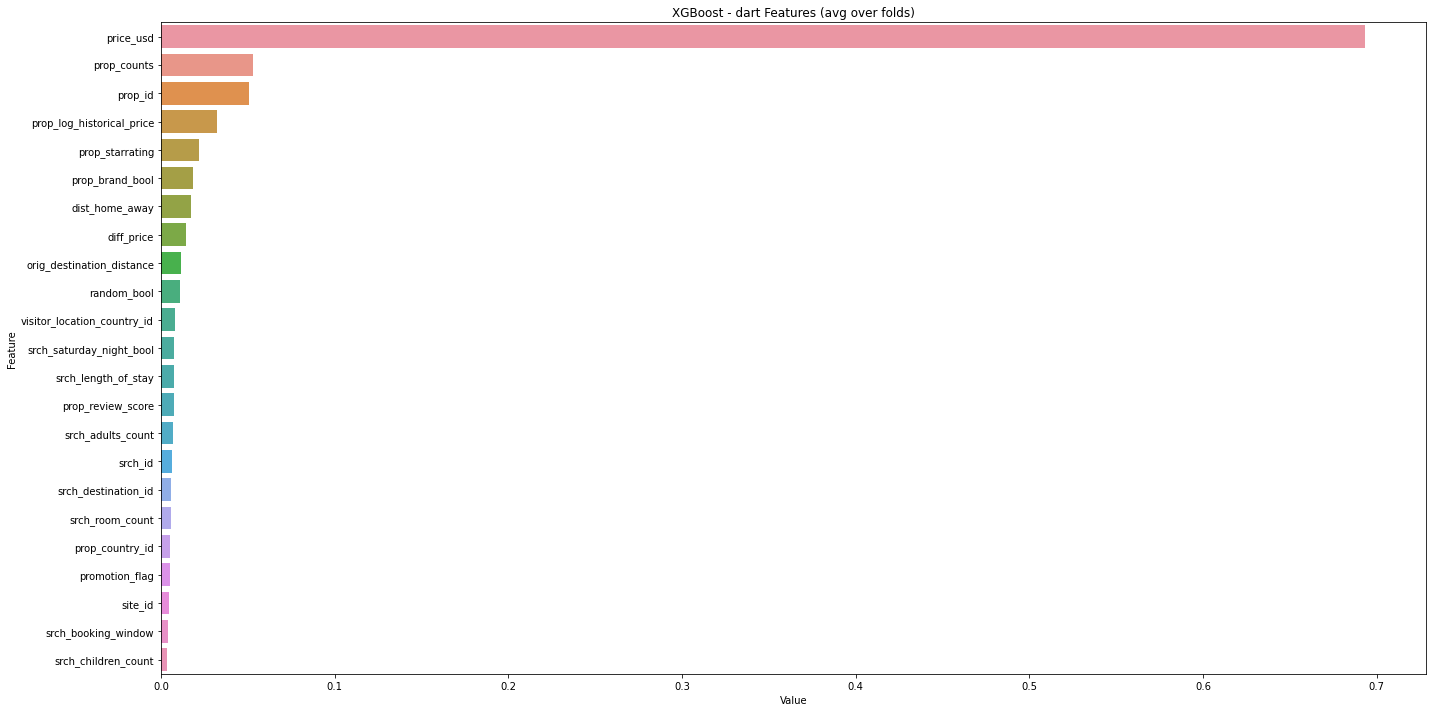

<Figure size 432x288 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_test)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost - dart Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('xgboost_dart_importances.png')

**No further feature engineering, including these features**

model_traindata = training_data[['srch_id',
                                   'site_id',
                                   'visitor_location_country_id',
                                   'prop_country_id',
                                   'prop_id',
                                   'prop_starrating',
                                   'prop_review_score',
                                   'prop_brand_bool',
                                   'prop_location_score1',
                                   'prop_location_score2',
                                   'prop_log_historical_price',
                                   'price_usd',
                                   'promotion_flag',
                                   'srch_destination_id',
                                   'srch_length_of_stay',
                                   'srch_booking_window',
                                   'srch_adults_count',
                                   'srch_children_count',
                                   'srch_room_count',
                                   'srch_saturday_night_bool',
                                   'orig_destination_distance',
                                   'random_bool',
                                   'target',
                                   'counts',
                                  ]]

NDCG score on training data XGBoost with objective `rank:ndcg`, booster `dart`, dropped NaNs, no further feature engineering = **0.7798114072823272**

*model = xgb.XGBRanker(  
    tree_method='hist',
    booster='dart',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )*


NDCG score on training data XGBoost with objective `rank:ndcg`, booster `gbtree`, dropped NaNs, no further feature engineering = **0.7793220497613718**

*model = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )*
   
    
NDCG score on training data XGBoost with objective `rank:ndcg`, booster `gbtree`, including NaNs, merge loc_scores = **0.7687506555406398**

*model = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )*
    

NDCG score on training data XGBoost with objective `rank:ndcg`, booster `dart`, replacing NaNs with zeroes, merge loc_scores = **0.768692374404902**

*model = xgb.XGBRanker(  
    tree_method='hist',
    booster='dart',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )*
    
    
NDCG score on training data XGBoost with objective `rank:ndcg`, booster `gbtree`, replacing NaNs with zeroes, merge loc_scores = **0.7686738092959273**

*model = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )*
    
    
NDCG score on training data XGBoost with objective `rank:ndcg`, booster `gbtree`, replacing NaNs with zeroes, 4 additional features = **0.767058746838947**
    
*model = xgb.XGBRanker(
    verbosity=3,
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )*
    
NDCG score on training data XGBoost with objective `rank:ndcg`, booster `gbtree`, replacing NaNs with zeroes, 4 additional features, optimized hyperparameters on CLASSIFIER = **0.7634965578579737**

*model = xgb.XGBRanker(
    verbosity=2,
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    reg_alpha=128,
    reg_lambda=0.15214262459317351,
    learning_rate=0.180656005953109,
    colsample_bytree=0.9956497639399737, 
    gamma=4.7115967519155895,
    eta=0.10615342984333002, 
    max_depth=3, 
    min_child_weight=1,
    n_estimators=145
    )*


NDCG score on training data XGBoost with objective `rank:ndcg`, booster `dart`, including NaNs, merge loc_scores = **?**

*model = xgb.XGBRanker(  
    tree_method='hist',
    booster='dart',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )*
    

NDCG score on training data XGBoost with objective `rank:ndcg`, booster `gbtree`, dropping NaNs, 4 additional features = **0.760910778134321**

*model = xgb.XGBRanker(
    verbosity=2,
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )*

NDCG score on training data XGBoost with objective `rank:ndcg`, booster `dart`, dropping NaNs, 4 additional features = **0.7608784443392484**

*model = xgb.XGBRanker(  
    tree_method='hist',
    booster='dart',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )*

In [53]:
test_data = pd.read_csv('data/test_set_VU_DM.csv')

In [54]:
z = test_data['prop_id'].value_counts() 
dict_z = z.to_dict() # converts to dictionary
test_data['prop_counts'] = test_data['prop_id'].map(dict_z)

In [55]:
test_data['diff_price'] = ((test_data['price_usd']) - (np.exp(test_data['prop_log_historical_price'])))

In [56]:
test_data['dist_home_away'] = (test_data['visitor_location_country_id']/test_data['prop_country_id'])
test_data.loc[test_data['dist_home_away']!=1, ['dist_home_away']] = 0

In [57]:
test_data['prop_loc_score1_norm'] = test_data['prop_location_score1'] / test_data['prop_location_score1'].abs().max()
test_data['prop_location_score2'].fillna(test_data['prop_loc_score1_norm'], inplace=True)
test_data['location_score'] = (test_data['prop_loc_score1_norm'] + test_data['prop_location_score2'])/2
test_data = test_data.drop('prop_loc_score1_norm', axis=1)

In [58]:
test_data

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,prop_counts,diff_price,dist_home_away,location_score
0,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,3180,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,185,-33.933013,0.0,0.245152
1,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,5543,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,252,-20.379512,0.0,0.231262
2,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,14142,2,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,150,-15.071523,0.0,0.221926
3,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,22393,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,147,-9.933013,0.0,0.199970
4,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,24194,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,214,-33.168253,0.0,0.315102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959178,332787,2013-05-21 11:06:37,24,216,NaN,NaN,117,32019,4,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,13,-26.688561,0.0,0.205200
4959179,332787,2013-05-21 11:06:37,24,216,NaN,NaN,117,33959,4,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,13,-13.540419,0.0,0.324793
4959180,332787,2013-05-21 11:06:37,24,216,NaN,NaN,117,35240,4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,-29.634348,0.0,0.256447
4959181,332787,2013-05-21 11:06:37,24,216,NaN,NaN,117,94437,4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7,-37.474348,0.0,0.257002


In [59]:
model_testdata = test_data[['srch_id',
                                 'site_id',
                                 'visitor_location_country_id',
                                 'prop_country_id',
                                 'prop_id',
                                 'prop_starrating',
                                 'prop_review_score',
                                 'prop_brand_bool',
                                 'prop_log_historical_price',
                                 'price_usd',
                                 'promotion_flag',
                                 'srch_destination_id',
                                 'srch_length_of_stay',
                                 'srch_booking_window',
                                 'srch_adults_count',
                                 'srch_children_count',
                                 'srch_room_count',
                                 'srch_saturday_night_bool',
                                 'orig_destination_distance',
                                 'random_bool',
                                 'prop_counts',
                                 'diff_price',
                                 'dist_home_away',
                                 'location_score'
                                ]]

In [60]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['srch_id'])])
  
test_predictions = (model_testdata.groupby('srch_id').apply(lambda x: predict(model, x)))

In [61]:
test_predictions

srch_id
1         [0.29785192, 0.23296428, -0.08665961, -0.70769...
3         [0.25781593, 0.55184, -1.2103857, 0.24470231, ...
6         [-0.027573049, -0.3180947, 0.0770804, -0.18007...
7         [-0.2843492, 0.3933191, 0.8274882, 0.065626025...
10        [0.79867345, 0.19792032, -1.0485796, 0.4437668...
                                ...                        
332781    [-0.71833766, -0.65348125, 0.14462155, -0.6043...
332783    [-0.3837945, 2.22335, 2.276816, 0.5551748, 1.0...
332785    [0.92671967, -1.0572425, 1.1799252, 0.35607347...
332786    [-0.0445188, -0.008980423, 0.37762198, 1.03864...
332787    [1.339456, 1.0778335, 0.72132885, 0.4644921, 0...
Length: 199549, dtype: object

In [62]:
y_testpred = []

for p in test_predictions:
    p = list(p)
    y_testpred.extend(p)

In [63]:
model_testdata["predicted_ranking"] = y_testpred

/var/folders/zb/qwtwsp1d539dg2nj7t84r7mc0000gn/T/ipykernel_46185/2849844749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_testdata["predicted_ranking"] = y_testpred


In [64]:
model_testdata = model_testdata.sort_values(["srch_id","predicted_ranking"], ascending=[True,False])

In [65]:
model_testdata.drop(model_testdata.columns.difference(['srch_id','prop_id']), 1, inplace=True)

In [66]:
model_testdata.to_csv("output-XGB-dart-features.csv", index=False) 